# ES7 Solution Sketch

:::{warning}
This is a working model framework.  Students will modify to fit the problem statement, formulate narrative answers, capture relevant graphics, etc.
:::

:::{tip}
Populate your solution report with the problem prompt, then backfill solution as modeling proceedes.
:::


Model build notes:

- memory purge script DONE
- problem set up database: IN PROGRESS
- import MF6 FloPy script DONE
- define workspace script DONE
- set simulation name: DONE
- set flow model name: DONE
- set time discretization: DONE
- set solver and register the flow model: DONE
- discretization for flow model: DONE
- initial conditions for flow model: DONE
- node property flow package: DONE
- storage package: DONE
- constant head package: DONE
- well package (if applicable): SKIP TRY 1
- output control for flow model: DONE
- **Attempt FLOW model run: SUCCESS; recode out of script**
- build starting concentration arrays: DONE
- set solver and register the transport model: DONE
- discretization for transport model: DONE
- transport initial concentrations: DONE (its why we built the arrays)
- set transport advection package: DONE
- set transport dispersion package: DONE
- set mass transfer package: DONE
- set source-sink mixing package: DONE
- set transport output control package: DONE
- set flow-transport exchange: DONE
- **Attempt FLOW+TRANSPORT model: SUCCESS; CHECK OUTPUTS >>> DEBUG K ERROR (FORGOT DAYS 2 SECONDS)**
- build output graphics: DONE

**Working Model Framework is Complete**

Modifications to complete assignment:
- Add three wells and verify drawdown looks OK.
- Add output code to get C(t) as a prescribed well.
- Probably add a few more stress periods to help capture plume arrival/departure at specific locations.  This will make plotting a bit cluttered, but the simulations themselves will be easier to manage.
- Mod mass transfer package to simulate effect of retardation.
- Mod mass transfer to simulate 1-st order decay.
- Get output plots captured and into report before next step
- Mod wells package to insert a remediation system (we only really get pump-and-treat to work with here)
- Complete report and hand-in your design and analysis


## Simulation Object Workflow

In [249]:
%reset -f

In [250]:
# purge memory and reset_environment
import sys

def reset_namespace():
    """Delete all user-defined global variables."""
    globs = globals().copy()
    for name in globs:
        if not name.startswith("__") and not isinstance(globs[name], type(sys)):
            del globals()[name]

reset_namespace()

In [251]:
# import packages for modflow6 and flopy
import os
import pathlib as pl
from pprint import pformat
import flopy
#import git
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from flopy.plot.styles import styles
#from modflow_devtools.misc import get_env, timed
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

## Problem Specific Database

In [252]:
#Problem set-up database and simulation control constants

# Console output flags
verbose = True # Used for tree-killing level of output; set to False for production run(s)

# Model units
length_units = "meters"
time_units = "seconds"

# Model grid geometry
nlay = 3  # Number of layers
nrow = 50  # Number of rows
ncol = 26  # Number of columns
# Layer 1 == top, Layer 2== middle, Layer 3 ==bottom
delr = 200.0*(1.0/3.28)  # Column width ($m$)
delc = 200.0*(1.0/3.28)  # Row width ($m$)
delz = [175.0*(1.0/3.28),15.0*(1.0/3.28),60.0*(1.0/3.28)]  # Layer thickness ($m$)
top = 3150.0*(1.0/3.28)  # Top of the model ($m$)
bottom = np.array([2975.0*(1.0/3.28),2960.0*(1.0/3.28),2900.0*(1.0/3.28)]) # layer bottom elevations


# Aquifer hydraulic properties
pors1 = 0.38
pors2 = 0.40
pors3 = 0.35
porosity = [pors1,pors2,pors3]  # Porosity
k1 = 25.0*(1.0/3.28)*(1/86400)  # Horiz. hyd. conductivity of top layer ($m/sec$)
k2 = 0.25*(1.0/3.28)*(1/86400)  # Horiz. hyd. conductivity of middlelayer ($m/sec$)
k3 = 30.0*(1.0/3.28)*(1/86400)  # Horiz. hyd. conductivity of bottom layer ($m/sec$)
hydcon = [k1,k2,k3]
stor1 = 0.20000
stor2 = 0.00040
stor3 = 0.00035
storativity = [stor1,stor2,stor3]

# Simulation layer types
laytyp = icelltype = 0  # this will need modification later on.  laytyp may need to be a list

# Aquifer transport properties
al = 10.0*(1/3.28) # Longitudinal dispersivity ($m$)
at =  1.0*(1/3.28) # Transverse dispersivity ($m$) 
### Assume dispeasuvuty same all layers
trpt = at/al  # Ratio of horiz. transverse to longitudinal dispersivity ($m$)
### If adsorbtion
kd = 0.20
### If 1st order decay
lamb = 1.0


# build porosity array(s)
pors_array = np.ones((nlay, nrow, ncol), dtype=float)
for ilay in range(nlay):
    pors_array[ilay] = porosity[ilay]*pors_array[ilay]
if verbose:
    print("\n porosity array(s)")
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:.2f}" for val in pors_array[ilay, irow, :]))

# build hydraulic conductivity array(s)
hk_array = np.ones((nlay, nrow, ncol), dtype=float)
for ilay in range(nlay):
    hk_array[ilay] = hydcon[ilay]*hk_array[ilay]
if verbose:
    print("\n hydraulic conductivity array(s)")
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:.2f}" for val in hk_array[ilay, irow, :]))

# build storativity array(s)
ss_array = np.ones((nlay, nrow, ncol), dtype=float)
for ilay in range(nlay):
    ss_array[ilay] = storativity[ilay]*ss_array[ilay]
if verbose:
    print("\n storage coefficient array(s)")
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:.4f}" for val in ss_array[ilay, irow, :]))
            
# build computation domain array(s)
idomain = np.ones((nlay, nrow, ncol), dtype=int)  # entire 3d domain
if verbose:
    print("\n computation domain array(s)")
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:3d}" for val in idomain[ilay, irow, :]))

# build boundary array(s) -- assume boundary conditions to all layers
# Boundaries
# Create a 3D array of zeros
ibound = np.zeros((nlay, nrow, ncol), dtype=int) # entire 3d domain
for ilay in range(nlay):
    ibound[ilay, 0, 0:21] = [-1 for i in range(ncol-5)] # top row all -1
    ibound[ilay,-1, 9:] = [-1 for i in range(9,ncol)] # bottom row all -1
    ##########################
    ibound[ilay,1,0]= -1 
    ibound[ilay,2,0]= -1 
    ibound[ilay,3,0]= -1 
    ##########################
    ibound[ilay,-2,-1]= -1 
    ibound[ilay,-3,-1]= -1 
    ibound[ilay,-4,-1]= -1 
    ibound[ilay,-5,-1]= -1 
if verbose:
    print("boundary condition array(s)")
#    print(ibound)
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:3d}" for val in ibound[ilay, irow, :]))

# Build initial conditions array(s)
# Create a 3D array of ones
inithead = (0.5*(3100+3040))*np.ones((nlay, nrow, ncol), dtype=float) # entire 3d domain set to 1.0
for ilay in range(nlay):
    inithead[ilay, 0,:] = [3100.0 for i in range(ncol)] # top row all -1
    inithead[ilay,-1,:] = [3040.0 for i in range(ncol)] # bottom row all -1
    ##########################
    inithead[ilay,1,0]= 3100.0
    inithead[ilay,2,0]= 3100.0 
    inithead[ilay,3,0]= 3100.0
    ##########################
    inithead[ilay,-2,-1]= 3040.0 
    inithead[ilay,-3,-1]= 3040.0 
    inithead[ilay,-4,-1]= 3040.0  
    inithead[ilay,-5,-1]= 3040.0 
if verbose:
    print("initial head condition array(s)")
#    print(ibound)
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:.0f}" for val in inithead[ilay, irow, :]))

############## TRANSPORT RELATED ##########################################

# Build starting concentration arrays(s)
sconc = np.zeros((nlay, nrow, ncol), dtype=float) # entire 3d domain set to 0.0
#
for ilay in range(1): # only upper layer is contaminated
    sconc[ilay,6,6:9] = [5.0 for i in range(3)] # 3 columns, row 7
    sconc[ilay,7,5:12] = [5.0 for i in range(7)]
    #
    sconc[ilay,8,5:13] = [5.0 for i in range(8)]
    sconc[ilay,8,6:10] = [100.0 for i in range(4)]
    #
    sconc[ilay,9,5:13] = [5.0 for i in range(8)]
    sconc[ilay,9,6:10] = [100.0 for i in range(4)]
    sconc[ilay,9,10:12] = [10.0 for i in range(2)]
    #
    sconc[ilay,10,5:13] = [5.0 for i in range(8)]
    sconc[ilay,10,6:9] = [500.0 for i in range(3)]
    sconc[ilay,10,9:10] = [100.0 for i in range(1)]
    sconc[ilay,10,10:11] = [50.0 for i in range(1)]
    sconc[ilay,10,11:12] = [10.0 for i in range(1)]
    #
    sconc[ilay,11,5:13] = [5.0 for i in range(8)]
    sconc[ilay,11,6:7] = [500.0 for i in range(1)]
    sconc[ilay,11,7:9] = [1000.0 for i in range(2)]
    sconc[ilay,11,9:10] = [100.0 for i in range(1)]
    sconc[ilay,11,10:11] = [50.0 for i in range(1)]
    sconc[ilay,11,11:12] = [10.0 for i in range(1)]
    #
    sconc[ilay,12,5:13] = [5.0 for i in range(8)]
    sconc[ilay,12,6:7] = [500.0 for i in range(1)]
    sconc[ilay,12,7:9] = [1000.0 for i in range(2)]
    sconc[ilay,12,9:10] = [100.0 for i in range(1)]
    sconc[ilay,12,10:11] = [50.0 for i in range(1)]
    sconc[ilay,12,11:12] = [10.0 for i in range(1)]
    #
    sconc[ilay,13,5:13] = [5.0 for i in range(8)]
    sconc[ilay,13,6:7] = [500.0 for i in range(1)]
    sconc[ilay,13,7:9] = [100.0 for i in range(2)]
    sconc[ilay,13,9:10] = [100.0 for i in range(1)]
    sconc[ilay,13,10:11] = [50.0 for i in range(1)]
    sconc[ilay,13,11:12] = [10.0 for i in range(1)]
    #
    sconc[ilay,14,5:13] = [5.0 for i in range(8)]
    sconc[ilay,14,6:7] = [10.0 for i in range(1)]
    sconc[ilay,14,7:9] = [50.0 for i in range(2)]
    sconc[ilay,14,9:10] = [50.0 for i in range(1)]
    sconc[ilay,14,10:11] = [50.0 for i in range(1)]
    sconc[ilay,14,11:12] = [10.0 for i in range(1)]
    #
    sconc[ilay,15,5:13] = [5.0 for i in range(8)]
    sconc[ilay,15,6:7] = [10.0 for i in range(1)]
    sconc[ilay,15,7:9] = [10.0 for i in range(2)]
    sconc[ilay,15,9:10] = [10.0 for i in range(1)]
    sconc[ilay,15,10:11] = [10.0 for i in range(1)]
    sconc[ilay,15,11:12] = [10.0 for i in range(1)]
    # 
    sconc[ilay,16,6:13] = [5.0 for i in range(7)]
    sconc[ilay,16,7:12] = [10.0 for i in range(5)]
    #
    sconc[ilay,17,7:13] = [5.0 for i in range(6)]
    sconc[ilay,17,11:12] = [10.0 for i in range(1)]
    #
    sconc[ilay,18,8:13] = [5.0 for i in range(5)]
    
if verbose:
    print("initial concentration array(s)")
#    print(ibound)
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:.1f}" for val in sconc[ilay, irow, :]))

# Build dispersivity arrays
al = 10.0*(1/3.28) # Longitudinal dispersivity ($m$)
trpt = 0.1  # Ratio of horiz. transverse to longitudinal dispersivity ($m$)

# Build distribution coefficient arrays
kd_b = 0.20

# Build 1st order decay arrays

decay_lambda = 0.00

# Build time information

# Time variables
perlen = [0.1 * 86400, 364.0 * 86400] #0.1 day initial, 1.0 years next period
steady = [True, True]
nper = len(perlen)
nstp = [1, 364]
tsmult = [1.0, 1.0]

# Solver settings
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
percel = 1.0  # HMOC parameters
itrack = 2
wd = 0.5
dceps = 1.0e-5
nplane = 0
npl = 0
nph = 16
npmin = 2
npmax = 32
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph
nadvfd = 1
mixelm = -1


 porosity array(s)

Layer 1
----------------------------------------------------------------------------------
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.3

In [253]:
# define workspace and executibles -- THISISMACHINE SPECIFIC
binary = "/home/sensei/mfplayground/modflow-python/mf6.4.1_linux/bin/mf6"  # location on MY computer of the compiled modflow program
directory_name = "es7_soln"
workarea = os.path.join("/home/sensei/ce-5364-webroot/mfexperiments", directory_name)
os.makedirs(workarea, exist_ok=True)

## Flow Model Workflow

In [254]:
# set simulation name(s)
name = "es7"
gwfname = "gwf-" + name
gwtname = "gwt-" + name

##### FLOPY build simulation framework ####
sim = flopy.mf6.MFSimulation(
    sim_name="sim-" + name, exe_name=binary, version="mf6", sim_ws=workarea
)

model_nam_file = f"{gwfname}.nam"

if gwfname in sim.model_dict:
    gwf = sim.get_model(gwfname)
    if verbose:
        print(f"GWF model '{gwfname}' already exists in sim.")
else:
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=model_nam_file,
    )
    if verbose:
        print(f"Created GWF model '{gwfname}' with name file {model_nam_file}")


Created GWF model 'gwf-es7' with name file gwf-es7.nam


In [255]:
###### Instantiating MODFLOW 6 time discretization               ########
tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
if verbose:
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)
    print("time discritization framework created into object: ""tdis_rc"" ")
else:
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units);

time discritization framework created into object: tdis_rc 


In [256]:
###### Instantiating MODFLOW 6 solver for flow model             ########
# Set Iterative Model Solution (choose solver parameters)
# about IMS see: https://water.usgs.gov/nrp/gwsoftware/ModelMuse/Help/sms_sparse_matrix_solution_pac.htm
# using defaults see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfims.html
imsgwf = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="CG",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename=f"{gwfname}.ims",
    )
if verbose:
    sim.register_ims_package(imsgwf, [gwf.name])
    print(f"solver framework created into object: {gwfname}.ims ")
else:
    sim.register_ims_package(imsgwf, [gwf.name]);   

solver framework created into object: gwf-es7.ims 


In [257]:
###### Instantiating MODFLOW 6 discretization for flow model     ########
if verbose:
    flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=bottom,
    idomain=idomain,
    filename=f"{gwfname}.dis",
    )
    print(f"grid framework created into object: {gwfname}.dis ")
else:
    flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=bottom,
    idomain=idomain,
    filename=f"{gwfname}.dis",
    );


grid framework created into object: gwf-es7.dis 


In [258]:
###### Instantiating MODFLOW 6 initial conditions for flow model ########
if verbose:
    flopy.mf6.ModflowGwfic(gwf, strt=inithead, filename=f"{gwfname}.ic")
    print(f"initial heads framework created into object: {gwfname}.ic ")
else:
    flopy.mf6.ModflowGwfic(gwf, strt=inithead, filename=f"{gwfname}.ic");

initial heads framework created into object: gwf-es7.ic 


In [259]:
###### Instantiating MODFLOW 6 node-property flow package        ########
if verbose:
    flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=True,
    icelltype=icelltype,
    k=hk_array,
    k33=hk_array,
    save_specific_discharge=True,
    filename=f"{gwfname}.npf",
    )
    print(f"node-property framework created into object: {gwfname}.npf ")
else:
    flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=True,
    icelltype=icelltype,
    k=hk_array,
    k33=hk_array,
    save_specific_discharge=True,
    filename=f"{gwfname}.npf",
    );

node-property framework created into object: gwf-es7.npf 


In [260]:
###### Instantiating MODFLOW 6 storage package                   ########
if verbose:
    sto = flopy.mf6.ModflowGwfsto(gwf,storagecoefficient=True, ss=ss_array)
    print("storage framework created into object: ""sto"" ")
else:
    sto = flopy.mf6.ModflowGwfsto(gwf,storagecoefficient=True, ss=ss_array);
## delete ";" in above line at end to show full output

########## Does storage need multi-period

storage framework created into object: sto 


In [261]:
### NEED FIX MULTIPLE STRESS PERIODS HERE ###
###### Instantiating MODFLOW 6 constant head package             ########
if verbose:
    chdspd = []
    for ilay in range(nlay):
        for irow in range(nrow):
            for jcol in range(ncol):
                if ibound[ilay,irow,jcol]==-1 and irow <= 6:
                    chdspd.append([(ilay, irow, jcol), 3100.0, 0.0]) # set head and concentration
                if ibound[ilay,irow,jcol]==-1 and irow >= 44:
                    chdspd.append([(ilay, irow, jcol), 3040.0, 0.0]) # set head and concentration              
    flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chdspd),
    stress_period_data=chdspd,
    save_flows=False,
    auxiliary="CONCENTRATION",
    pname="CHD-1",
    filename=f"{gwfname}.chd",
    )
    print(f"constant head framework created into object: {gwfname}.chd ")
else:
    chdspd = []
    for ilay in range(nlay):
        for irow in range(nrow):
            for jcol in range(ncol):
                if ibound[ilay,irow,jcol]==-1 and irow <= 6:
                    chdspd.append([(ilay, irow, jcol), 3100.0, 0.0]) # set head and concentration
                if ibound[ilay,irow,jcol]==-1 and irow >= 44:
                    chdspd.append([(ilay, irow, jcol), 3040.0, 0.0]) # set head and concentration              
    flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chdspd),
    stress_period_data=chdspd, #<<<<<<<<<<<<<<<<<<<<<<<< HERE
    save_flows=False,
    auxiliary="CONCENTRATION",
    pname="CHD-1",
    filename=f"{gwfname}.chd",
    );
## delete ";" in above line at end to show full output

constant head framework created into object: gwf-es7.chd 


In [262]:
###### Instantiating MODFLOW 6 well package (if applicable)      ########
if verbose:
    print("no wells this simulation")
else:
    pass

no wells this simulation


In [263]:
###### Instantiating MODFLOW 6 output control for flow model     ########
if verbose:
    flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{gwfname}.hds",
    budget_filerecord=f"{gwfname}.bud",
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
##    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
##    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    print(f"output control for flow model created into objects {gwfname}.hds and {gwfname}.bud ")
else:
    flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{gwfname}.hds",
    budget_filerecord=f"{gwfname}.bud",
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
##    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
##    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    );

output control for flow model created into objects gwf-es7.hds and gwf-es7.bud 


## Transport Model Workflow

In [264]:
###### Instantiating MODFLOW 6 groundwater transport model (GWT) ######
gwt_nam_file = f"{gwtname}.nam" # gwt is defined in the initial simulation build block

if gwtname in sim.model_dict:
    gwt = sim.get_model(gwtname)
    if verbose:
        print(f"GWT model '{gwtname}' already exists in sim.")
        print(f"Name file:", gwt.name_file.filename)
else:
    gwt = flopy.mf6.ModflowGwt(
        sim,
        modelname=gwtname,
        save_flows=True,
        model_nam_file=gwt_nam_file,
    )
    if verbose:
        print(f"Created GWT model '{gwtname}' with name file {gwt_nam_file}")


Created GWT model 'gwt-es7' with name file gwt-es7.nam


In [265]:
# create iterative model solution and register the gwt model with it
imsgwt = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename=f"{gwtname}.ims",
    )


if verbose:
    sim.register_ims_package(imsgwt, [gwt.name])
    print(f"transport solver framework created into object: {gwtname}.ims ")
else:
    sim.register_ims_package(imsgwt, [gwt.name]);   

transport solver framework created into object: gwt-es7.ims 


In [266]:
###### Instantiating MODFLOW 6 discretization for transport model     ########
if verbose:
    flopy.mf6.ModflowGwtdis(
    gwt,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=bottom,
    idomain=idomain,
    filename=f"{gwtname}.dis",
    )
    print(f"transport grid framework created into object: {gwtname}.dis ")
else:
    flopy.mf6.ModflowGwtdis(
    gwt,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=bottom,
    idomain=idomain,
    filename=f"{gwtname}.dis",
    );
# Observe subtle name differences in both the name "gwt" and the API function call: flopy.mf6.ModflowGwtdis""

transport grid framework created into object: gwt-es7.dis 


In [267]:
# Instantiating MODFLOW 6 transport initial concentrations
flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic");
## delete ";" in above line at end to show full output

In [268]:
# Instantiating MODFLOW 6 transport advection package
if mixelm >= 0:
    scheme = "UPSTREAM"
elif mixelm == -1:
    scheme = "TVD"
else:
    raise Exception()
    
if verbose:
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")
    print("Advection package in file " + f"{gwtname}.adv")
else:
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv");

Advection package in file gwt-es7.adv


In [269]:
# Instantiating MODFLOW 6 transport dispersion package
# NOTE TO FUTURE SELF / STUDENTS:
# al and at are currently scalars for teaching clarity.
# MODFLOW 6 accepts full arrays (nlay, nrow, ncol) or lists of layer arrays.
# To upgrade:
#   • Replace `if al != 0:` with  `if np.any(al != 0):`
#   • Pass arrays directly: alh=al, ath1=at
#   • Or pass per-layer lists: alh=[al0, al1, ...]
if al != 0:
    flopy.mf6.ModflowGwtdsp(
        gwt,
        alh=al, # longitudinal
        ath1=at, # transverse
        filename=f"{gwtname}.dsp",
        )
    print("Dispersion package in file " + f"{gwtname}.dsp")

Dispersion package in file gwt-es7.dsp


In [270]:
# Instantiating MODFLOW 6 transport mass storage package
flopy.mf6.ModflowGwtmst(
    gwt,
    porosity=pors_array,
    first_order_decay=False,
    decay=None,
    decay_sorbed=None,
    sorption=None,
    bulk_density=None,
    distcoef=None,
    filename=f"{gwtname}.mst",
    )
print("Mass Transfer package in file " + f"{gwtname}.mst")

Mass Transfer package in file gwt-es7.mst


In [271]:
# Instantiating MODFLOW 6 transport source-sink mixing package
#sourcerecarray = [
#   ("WEL-1", "AUX", "CONCENTRATION"),
#  ("CHD-1", "AUX", "CONCENTRATION"),
# ]
sourcerecarray = [
    ("CHD-1", "AUX", "CONCENTRATION"),
    ]
flopy.mf6.ModflowGwtssm(
    gwt,
    sources=sourcerecarray,
    print_flows=True,
    filename=f"{gwtname}.ssm",
    )
print("Source-sink mixing package in file " + f"{gwtname}.ssm")

Source-sink mixing package in file gwt-es7.ssm


In [272]:
# Instantiating MODFLOW 6 transport output control package
flopy.mf6.ModflowGwtoc(
    gwt,
    budget_filerecord=f"{gwtname}.cbc",
    concentration_filerecord=f"{gwtname}.ucn",
    concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    filename=f"{gwtname}.oc",
    )
print("Transport model output control package in file " + f"{gwtname}.oc")

Transport model output control package in file gwt-es7.oc


In [273]:
# Instantiating MODFLOW 6 flow-transport exchange mechanism
print(name)
flopy.mf6.ModflowGwfgwt(
    sim,
    exgtype="GWF6-GWT6",
    exgmnamea=gwfname,
    exgmnameb=gwtname,
    filename=f"{name}.gwfgwt",
    );
## delete ";" in above line at end to show full output

es7


## Attempt the simulation run(s)

In [274]:
sim.write_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing package es7.gwfgwt...
  writing model gwf-es7...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package chd-1...
    writing package oc...
  writing model gwt-es7...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package oc...


In [275]:
# Attempt to run MODFLOW this model
if verbose:
    silent = False
    report = True
else:
    silent = True
    report = False

# manual override(s):
silent=True
report=False

success, buff = sim.run_simulation(silent=silent, report=report)

if success:
    print("\033[1;32mMODFLOW 6 normal termination.\033[0m")   # bold green
else:
    print("\033[1;31mMODFLOW 6 did NOT terminate normally!\033[0m")  # bold red
    raise Exception("MODFLOW 6 did not terminate normally.")

MODFLOW 6 normal termination.


## Flow Model – Post-Processing

A sanity check on the model’s hydraulics we should ask ourselves:

1. Do heads decrease in the expected down-gradient direction?
2. Are vertical gradients consistent with the conceptual hydrogeologic system (unconfined → aquitard → leaky confined)?
3. Do pumping wells induce appropriate drawdowns in the correct layers?
4. Are boundary conditions behaving as intended (constant head, no-flow, or others)?
5. Is the system numerically stable (no oscillations, unreasonable values, or artifacts)?

If the hydraulic field is incorrect, any subsequent GWT transport simulation will also be incorrect—since advective velocities and flow exchanges come directly from this flow solution.

In [276]:
hobj = gwf.output.head()

print("=== Head file explorer ===")
print("kstp,kper combos:", hobj.get_kstpkper())
print("Times:", hobj.get_times())

# Get last timestep by default
h = hobj.get_data()
print("Head array shape:", h.shape)
print("Layer count:", h.shape[0])

for k in range(h.shape[0]):
    print(f"Layer {k+1}: min={h[k].min():.3f}, max={h[k].max():.3f}")


=== Head file explorer ===
kstp,kper combos: [(np.int32(0), np.int32(0)), (np.int32(363), np.int32(1))]
Times: [np.float64(8640.0), np.float64(31458240.0)]
Head array shape: (3, 50, 26)
Layer count: 3
Layer 1: min=3040.000, max=3100.000
Layer 2: min=3040.000, max=3100.000
Layer 3: min=3040.000, max=3100.000


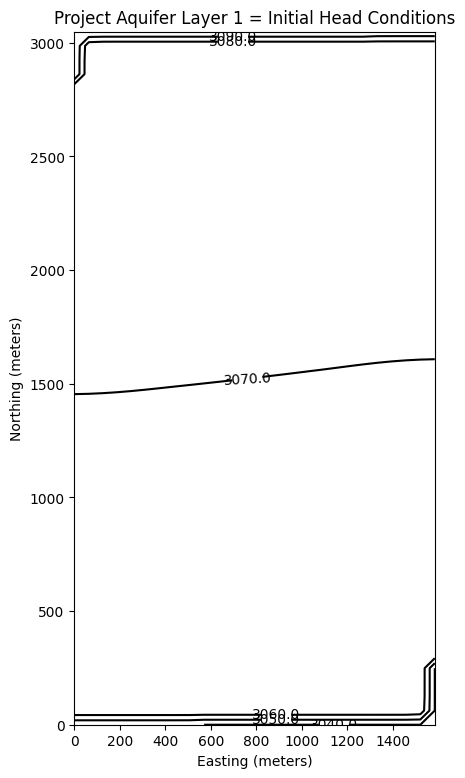

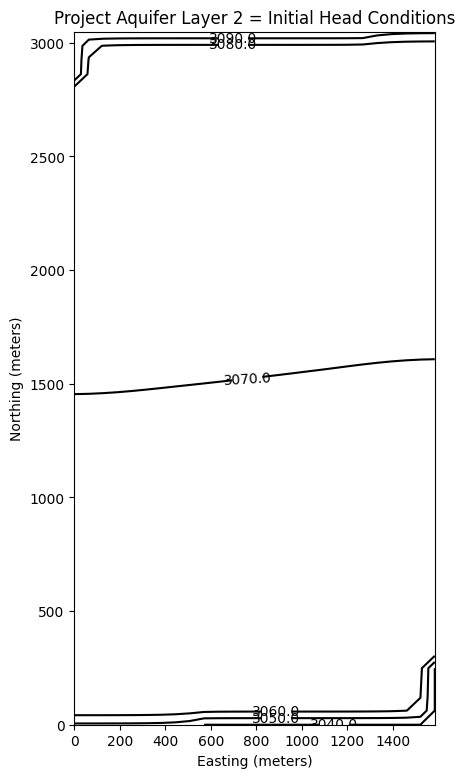

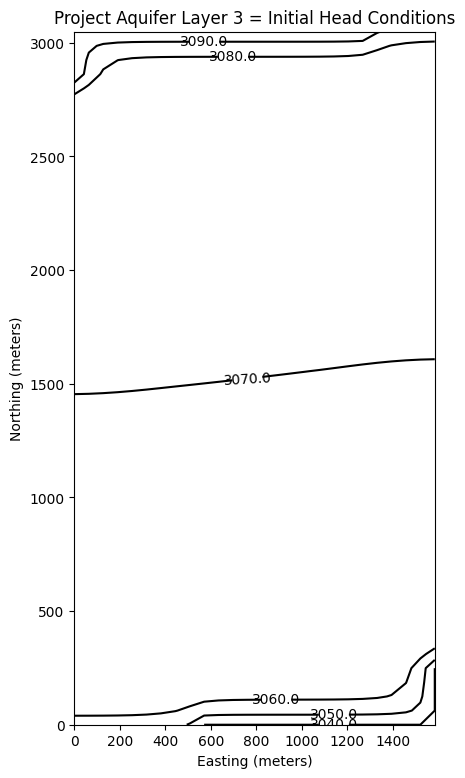

In [277]:
## now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(0, 0))
#print(h[0])
x =  np.linspace(0, delc*ncol, ncol)
y =  np.linspace(0, delr*nrow, nrow)
y = y[::-1]
vmin, vmax = 2900.0, 3210.0
contour_intervals = np.arange(2900.0, 3210.0, 10.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 1 = Initial Head Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 2

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[1], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 2 = Initial Head Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 3

#print(h[2].max())

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[2], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 3 = Initial Head Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

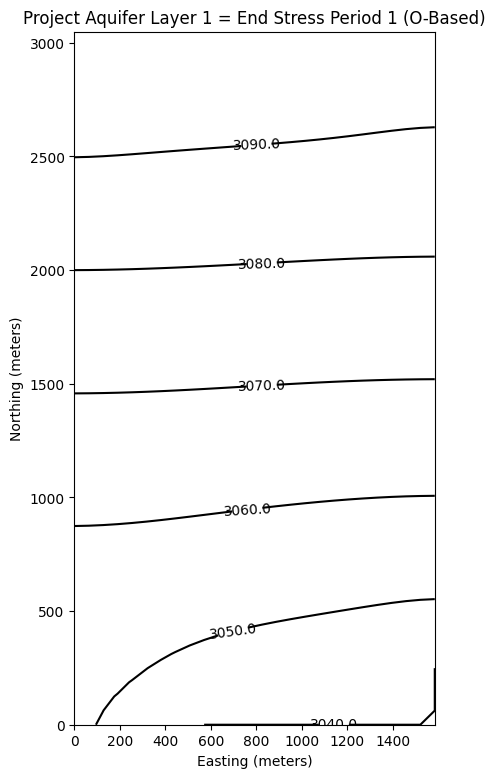

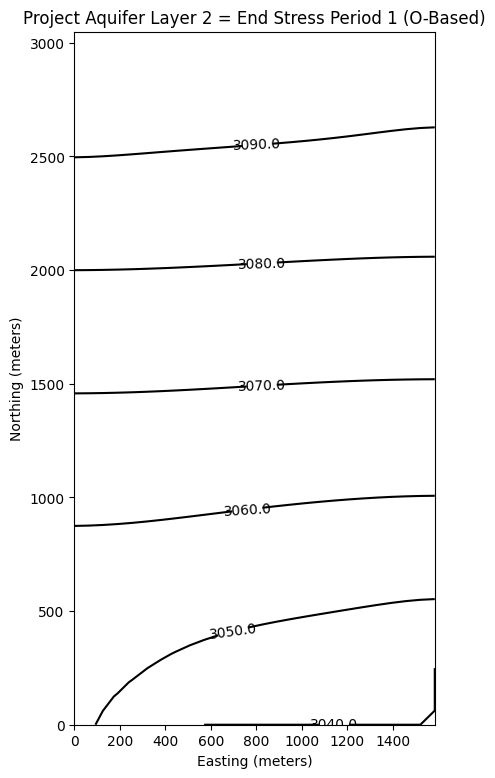

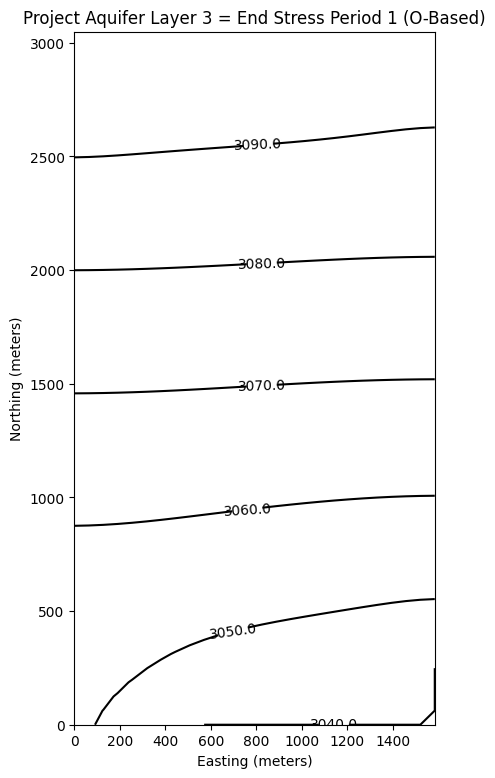

In [278]:
## now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(363, 1))
#print(h[0])
x =  np.linspace(0, delc*ncol, ncol)
y =  np.linspace(0, delr*nrow, nrow)
y = y[::-1]
vmin, vmax = 2900.0, 3210.0
contour_intervals = np.arange(2900.0, 3210.0, 10.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 1 = End Stress Period 1 (O-Based)")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 2

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[1], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 2 = End Stress Period 1 (O-Based)")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 3

#print(h[2].max())

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[2], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 3 = End Stress Period 1 (O-Based)")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

## Transport Model - Post Processing

Here we are rendering the plume evolution over time - and possibly other important interpretation.

As a sanity check we should ask ourselves:

1. Does the plume move in the expected down-gradient direction?
2. Are vertical gradients consistent with the conceptual hydrogeologic system (unconfined → aquitard → leaky confined)?
3. Do pumping wells induce appropriate drawdowns in the correct layers?
4. Are boundary conditions behaving as intended (constant head, no-flow, or others)?
5. Is the system numerically stable (no oscillations, unreasonable values, or artifacts)?

Here the sample supplies some minimal plotting tools to help build a report - naturally as you complete the project some parts might change/evolve.

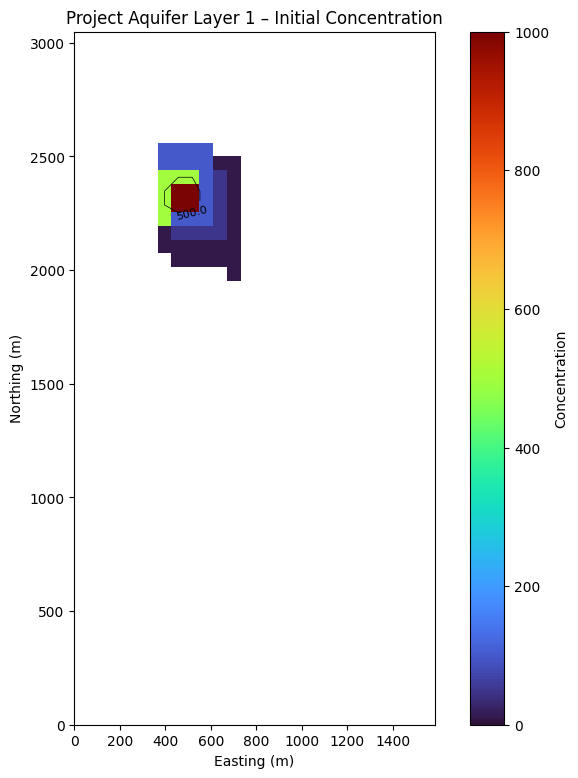

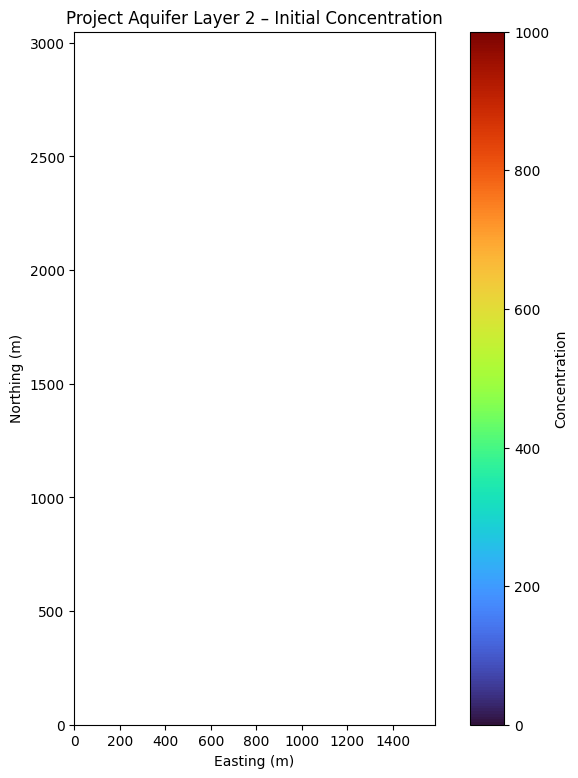

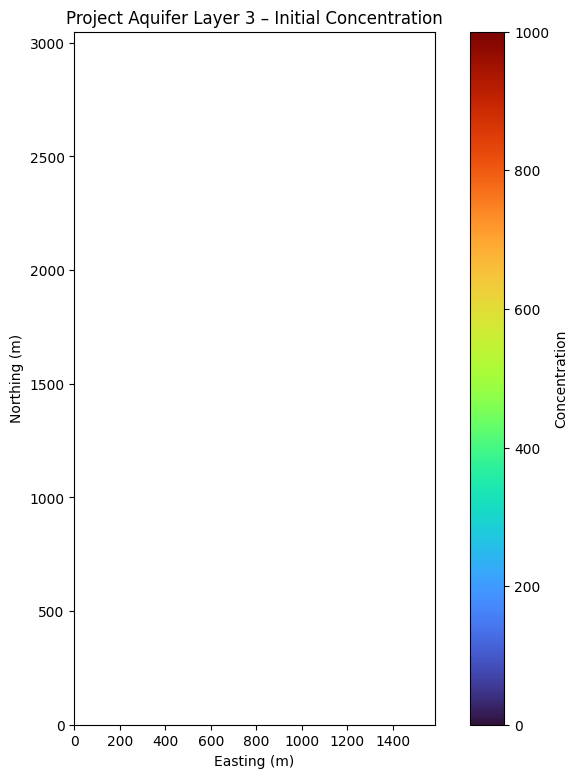

In [279]:
# Get concentration at a specific time (kstp=0, kper=0)
conc = gwt.output.concentration().get_data(kstpkper=(0, 0))  # shape (nlay, nrow, ncol)
# Now we already have:
# conc  : (nlay, nrow, ncol)
# delr  : row spacing
# delc  : column spacing
# nrow, ncol defined
nlay, nrow, ncol = conc.shape

# Cell center coordinates (for contour)
x_centers = np.linspace(0.5 * delc, delc * (ncol - 0.5), ncol)
y_centers = np.linspace(0.5 * delr, delr * (nrow - 0.5), nrow)
y_centers = y_centers[::-1]  # if you want row 0 at top (northing increasing upward)

# Cell edge coordinates (for pcolormesh)
x_edges = np.linspace(0, delc * ncol, ncol + 1)
y_edges = np.linspace(0, delr * nrow, nrow + 1)
y_edges = y_edges[::-1]      # match the flip above

X_edges, Y_edges = np.meshgrid(x_edges, y_edges)


import numpy as np
import matplotlib.pyplot as plt

contour_levels = np.arange(0.0, 1000.0 + 1e-6, 500.0)

base_cmap = plt.cm.get_cmap("turbo").copy()  # or "bwr", "jet", etc.
base_cmap.set_bad("white")                   # masked values → white

vmin, vmax = 0.0, 1000.0  # or use conc.min()/conc.max() if you prefer


for layer in range(nlay):
    layer_data = conc[layer]
    layer_masked = np.ma.masked_less_equal(layer_data, 5.0)

    fig, ax = plt.subplots(figsize=(9, 9))

    im = ax.pcolormesh(
        X_edges,
        Y_edges,
        layer_masked,
        cmap=base_cmap,
        vmin=vmin,
        vmax=vmax,
        shading="auto",
    )

    c = ax.contour(
        x_centers,
        y_centers,
        layer_masked,
        levels=contour_levels,
        colors="black",
        linewidths=0.5,
    )

    ax.set_aspect("equal")
    ax.set_title(f"Project Aquifer Layer {layer+1} – Initial Concentration")
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
# Toggle block OFF/ON as needed
    #ax.set_xticks(x_edges)
    #ax.set_yticks(y_edges)
    #ax.grid(True, color="black", linewidth=0.5, alpha=0.4)

    plt.clabel(c, fmt="%2.1f", inline=True, fontsize=8)
    plt.colorbar(im, ax=ax, label="Concentration")

    plt.show()


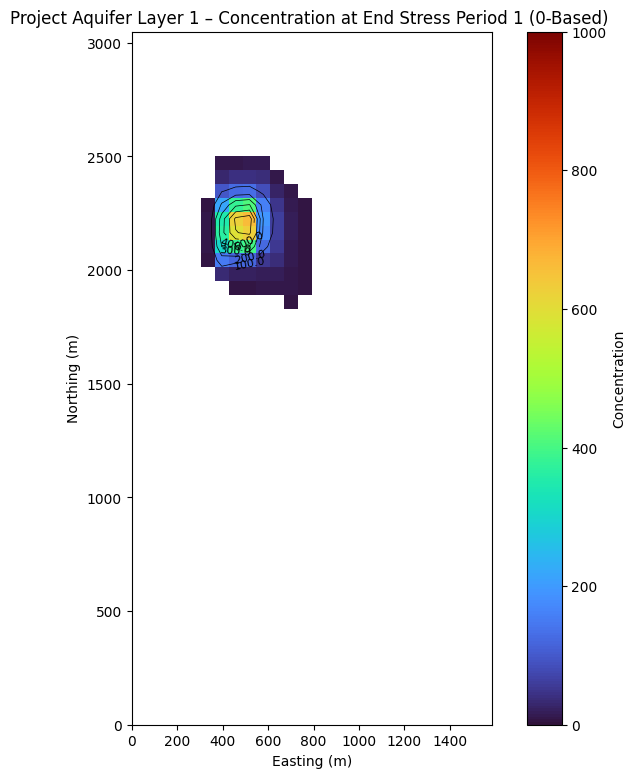

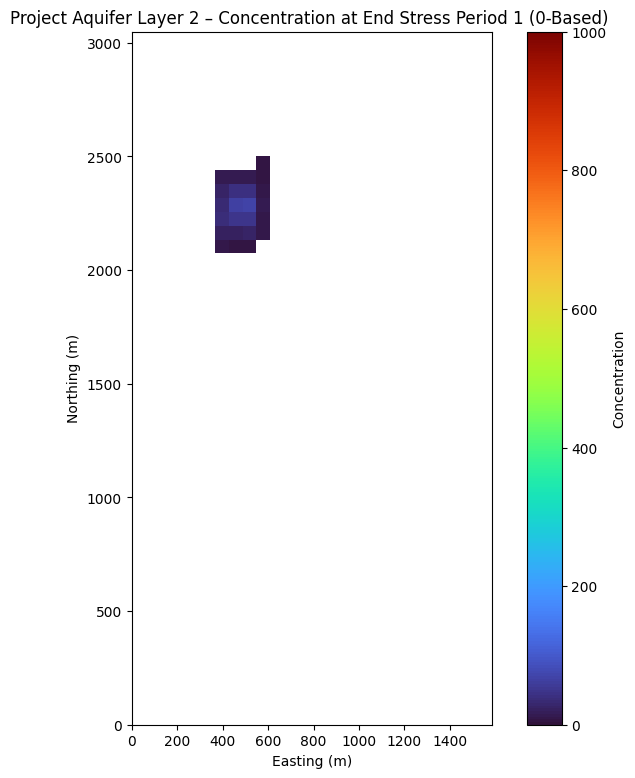

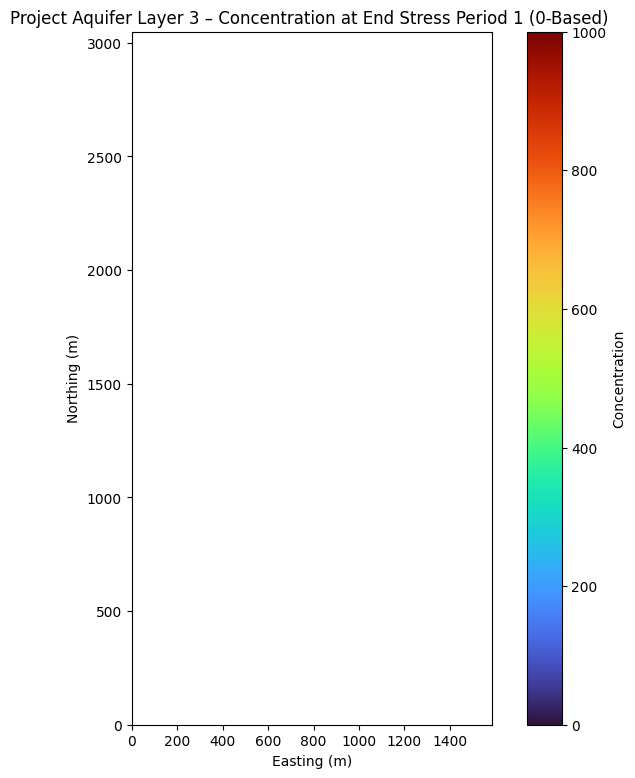

In [280]:
# Assuming you already have:
# conc  : (nlay, nrow, ncol)
# delr  : row spacing
# delc  : column spacing
# nrow, ncol defined

# Get concentration at a specific time (kstp=0, kper=0)
conc = gwt.output.concentration().get_data(kstpkper=(363, 1))  # shape (nlay, nrow, ncol)
# Now we already have:
# conc  : (nlay, nrow, ncol)
# delr  : row spacing
# delc  : column spacing
# nrow, ncol defined
nlay, nrow, ncol = conc.shape

# Cell center coordinates (for contour)
x_centers = np.linspace(0.5 * delc, delc * (ncol - 0.5), ncol)
y_centers = np.linspace(0.5 * delr, delr * (nrow - 0.5), nrow)
y_centers = y_centers[::-1]  # if you want row 0 at top (northing increasing upward)

# Cell edge coordinates (for pcolormesh)
x_edges = np.linspace(0, delc * ncol, ncol + 1)
y_edges = np.linspace(0, delr * nrow, nrow + 1)
y_edges = y_edges[::-1]      # match the flip above

X_edges, Y_edges = np.meshgrid(x_edges, y_edges)


import numpy as np
import matplotlib.pyplot as plt

contour_levels = np.arange(0.0, 1000.0 + 1e-6, 100.0)

base_cmap = plt.cm.get_cmap("turbo").copy()  # or "bwr", "jet", etc.
base_cmap.set_bad("white")                   # masked values → white

vmin, vmax = 0.0, 1000.0  # or use conc.min()/conc.max() if you prefer


for layer in range(nlay):
    layer_data = conc[layer]
    layer_masked = np.ma.masked_less_equal(layer_data, 5.0)

    fig, ax = plt.subplots(figsize=(9, 9))

    im = ax.pcolormesh(
        X_edges,
        Y_edges,
        layer_masked,
        cmap=base_cmap,
        vmin=vmin,
        vmax=vmax,
        shading="auto",
    )

    c = ax.contour(
        x_centers,
        y_centers,
        layer_masked,
        levels=contour_levels,
        colors="black",
        linewidths=0.5,
    )

    ax.set_aspect("equal")
    ax.set_title(f"Project Aquifer Layer {layer+1} – Concentration at End Stress Period 1 (0-Based) ")
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")

#    ax.set_xticks(x_edges)
#    ax.set_yticks(y_edges)
#    ax.grid(True, color="black", linewidth=0.5, alpha=0.4)

    plt.clabel(c, fmt="%2.1f", inline=True, fontsize=8)
    plt.colorbar(im, ax=ax, label="Concentration")

    plt.show()


## Appendix — Development Notes

The material below contains exploratory code used during model development. Although these snippets are not required in the final report, they illustrate the iterative process of building a working numerical model and producing reliable visualizations.

Modeling rarely proceeds in a straight line; adjustments to scaling, plotting parameters, velocity checks, and output interpretation are all part of developing a defensible analysis. The examples here are retained to show how trial-and-error, testing, and debugging contribute to clearer and more trustworthy results.

These scripts are also the product of a collaborative human–AI workflow, with OpenAI assisting through targeted guidance and example code, and the author integrating, refining, and validating each element. This serves as a contemporary example of how human expertise and AI-assisted development can work together to accelerate learning, highlight pitfalls, and produce improved analytical tools.

For instructional purposes, the steps are presented as Markdown cells with embedded Python (using the ```python … ``` format). Students and practitioners may reproduce, adapt, or extend them to support their own model verification and visualization workflows.

```text
**Activate Cells Below to Test Flow Model ONLY**

The transport model will throw an error unless blocks below are suppressed (or you know what to change in the .nam files)
```

```python
# Write files to the directory - FLOW MODEL ONLY
if verbose:
    sim.write_simulation()
else:
    sim.write_simulation();
```

```python
# Attempt to run MODFLOW this model
if verbose:
    silent = False
else:
    silent = True

success, buff = sim.run_simulation(silent=silent, report=True)

if success:
    print("\033[1;32mMODFLOW 6 normal termination.\033[0m")   # bold green
else:
    print("\033[1;31mMODFLOW 6 did NOT terminate normally!\033[0m")  # bold red
    raise Exception("MODFLOW 6 did not terminate normally.")
```

```text
## Flow Model – Post-Processing and Hydraulic Reasonableness Check

Before moving on to transport modeling, it is essential to verify that the groundwater flow solution behaves in a physically reasonable way. In this section, we will visualize the simulated hydraulic head distribution in all three layers for both the initial and final times of the steady-state run (recall that for steady flow, these should be identical unless transient storage was activated).

The goal here is not yet to interpret plume behavior or evaluate well impacts.
Instead, we are performing a sanity check on the model’s hydraulics:

Do heads decrease in the expected down-gradient direction?

Are vertical gradients consistent with the conceptual hydrogeologic system (unconfined → aquitard → leaky confined)?

Do pumping wells induce appropriate drawdowns in the correct layers?

Are boundary conditions behaving as intended (constant head, no-flow, or others)?

Is the system numerically stable (no oscillations, unreasonable values, or artifacts)?

If the hydraulic field is incorrect, any subsequent GWT transport simulation will also be incorrect—since advective velocities and flow exchanges come directly from this flow solution.

For now, we will generate plots of heads in Layer 1, Layer 2, and Layer 3.
Later, once the hydraulics are validated, we may choose to suppress or streamline these plots to focus on the actual transport problems in Exercise Set 7.
```

```python
hobj = gwf.output.head()

print("=== Head file explorer ===")
print("kstp,kper combos:", hobj.get_kstpkper())
print("Times:", hobj.get_times())

# Get last timestep by default
h = hobj.get_data()
print("Head array shape:", h.shape)
print("Layer count:", h.shape[0])

for k in range(h.shape[0]):
    print(f"Layer {k+1}: min={h[k].min():.3f}, max={h[k].max():.3f}")
```

```python
## now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(364, 0))
print(h[0])
x =  np.linspace(0, delc*ncol, ncol)
y =  np.linspace(0, delr*nrow, nrow)
y = y[::-1]
vmin, vmax = 2900.0, 3210.0
contour_intervals = np.arange(2900.0, 3210.0, 10.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 1 = PreDevelopment Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 2

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[1], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 2 = PreDevelopment Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 3

print(h[2].max())

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[2], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 3 = PreDevelopment Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");
```

```python
## now attempt to postprocess
conc = gwt.output.concentration().get_data(kstpkper=(0, 0))
#print(h[0])
x =  np.linspace(0, delc*ncol, ncol)
y =  np.linspace(0, delr*nrow, nrow)
y = y[::-1]
vmin, vmax = 2900.0, 3210.0
contour_intervals = np.arange(0.0, 1000.0, 100.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, conc[0], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 1 = Initial Concentration Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 2

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, conc[1], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 2 = Initial Concentration Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 3

#print(h[2].max())

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, conc[2], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 3 = Initial Concentration Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");
```

```python
# Get concentration at a specific time (kstp=0, kper=0)
conc = gwt.output.concentration().get_data(kstpkper=(0, 0))  # shape (nlay, nrow, ncol)

# Build coordinate vectors
x = np.linspace(0, delc * ncol, ncol)
y = np.linspace(0, delr * nrow, nrow)
y = y[::-1]  # if your grid is flipped in y

# Define contour levels (adjust as needed)
contour_intervals = np.arange(0.0, 1000.0 + 1e-6, 100.0)

# Build a colormap: blue→red, with <=0 masked/white
base_cmap = plt.cm.get_cmap("bwr").copy()  # blue-white-red
base_cmap.set_bad("white")                 # masked values will be white

for k in range(conc.shape[0]):  # loop over layers
    layer_data = conc[k]

    # Mask nonpositive values so they plot as white
    layer_masked = np.ma.masked_less_equal(layer_data, 5.0)

    fig, ax = plt.subplots(figsize=(9, 9))
    cf = ax.contourf(
        x,
        y,
        layer_masked,
        levels=contour_intervals,
        cmap=base_cmap,
        extend="max",  # colorbar extends upward; masked are white
    )

    # Optional: add black contour lines on top
    c = ax.contour(x, y, layer_masked, levels=contour_intervals,
                   colors="black", linewidths=0.5)

    ax.set_aspect("equal")
    ax.set_title(f"Project Aquifer Layer {k+1} – Initial Concentration")
    ax.set_xlabel("Easting (meters)")
    ax.set_ylabel("Northing (meters)")
    plt.clabel(c, fmt="%2.1f", inline=True, fontsize=8)

    cb = plt.colorbar(cf, ax=ax, label="Concentration")
    plt.show()
```

```python
layer = 0  # 0-based: 0, 1, 2 for layers 1, 2, 3, etc.

layer_data = conc[layer]  # shape (nrow, ncol)

# Mask non-positive values so they plot as white
layer_masked = np.ma.masked_less_equal(layer_data, 5.0)

fig, ax = plt.subplots(figsize=(9, 9))

# 1) Raster-like colored cells
im = ax.pcolormesh(
    X_edges,
    Y_edges,
    layer_masked,
    cmap=base_cmap,
    vmin=vmin,
    vmax=vmax,
    shading="auto",
)

# 2) Contour lines on top (use centers)
c = ax.contour(
    x_centers,
    y_centers,
    layer_masked,
    levels=contour_levels,
    colors="black",
    linewidths=0.5,
)

ax.set_aspect("equal")
ax.set_title(f"Project Aquifer Layer {layer+1} – Concentration")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

plt.clabel(c, fmt="%2.1f", inline=True, fontsize=8)
cb = plt.colorbar(im, ax=ax, label="Concentration")

plt.show()
```

```python
# ### Plot a Map of Layer 1 (Filled Contours)

contour_intervals = np.arange(5.0, 1005.0, 95.0)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Filled contour (use viridis or default if preferred; here we’ll use 'turbo')
cf = ax.contourf(x, y, sconc[0], contour_intervals, cmap="turbo")  

# Optional black contour lines for clarity
c = ax.contour(x, y, sconc[0], contour_intervals, colors="black", linewidths=0.6)

plt.title("Project Aquifer Layer 1 — Initial Concentration Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")

# Add contour labels only if not too dense
plt.clabel(c, fmt="%2.1f", inline=True, fontsize=8)

# Add a colorbar
cb = plt.colorbar(cf, ax=ax, label="Concentration")

plt.show()
```

```python
cobj  = gwt.output.concentration()
klist = cobj.get_kstpkper()
times = cobj.get_times()

print("Total saved times:", len(times))
for i, (kstp, kper) in enumerate(klist[:5]):  # first 5 only
    c_t = cobj.get_data(kstpkper=(kstp, kper))
    print(f"\n=== i={i}, kper={kper}, kstp={kstp}, totim={times[i]:.3f} ===")
    for k in range(c_t.shape[0]):
        print(f"  Layer {k+1}: min={c_t[k].min():.3f}, max={c_t[k].max():.3f}")
```

```python
cobj = gwt.output.concentration()

print("=== Concentration file explorer ===")
print("kstp,kper combos:", cobj.get_kstpkper())
print("Times:", cobj.get_times())

# Get last timestep by default
c = cobj.get_data()
print("Concentration array shape:", c.shape)
print("Layer count:", c.shape[0])

for k in range(c.shape[0]):
    print(f"Layer {k+1}: min={c[k].min():.3f}, max={c[k].max():.3f}")
```

```python
def browse_output(obj):
    print(f"=== {obj.__class__.__name__} Explorer ===")
    print("kstp,kper:", obj.get_kstpkper())
    print("times:", obj.get_times())
    arr = obj.get_data()
    print("shape:", arr.shape)
    for k in range(arr.shape[0]):
        print(f" Layer {k+1}: min={arr[k].min():.3f}, max={arr[k].max():.3f}")

# Usage:
browse_output(gwt.output.concentration())
```